In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MTS.Teta Summer school

Данные из приложения МТС Библиотека по взаимодействиям пользователей с книгами за 2 года.

В отдельных файлах есть:

* факты чтения книг пользователями
* описание книг
* описание пользователей


<b>Описание данных: </b>

В датасете собраны данные по пользователям и книгам, а также по их взаимодействиям (прочтение книги пользователем) из сервиса МТС Библиотека. Данные по чтению пользователями книг собраны за 2 два года, с 01-01-2018 по 31-12-2019 включительно, и разбавлены случайным шумом. ID пользователей и книг анонимизированы.

МТС Библиотека - приложение для чтения электронных книг, прессы и прослушивания аудиокниг, доступно для абонентов всех мобильных операторов, продукт экосистемы МТС. 

<b> Задача: </b>

Необходимо наиболее точно порекомендовать список из 10 книг для каждого пользователя из тестовой выборки. На платформе соревнования хранится тестовая выборка с реальными данными (пользователями и книгами, которые они прочитали за эти 2 дня). Данные скрыты. Kaggle посчитает метрику качества вашего предсказания: насколько оно совпадает с реальными данными

<b> Метрика качества: </b>   
Метрика качества в соревновании - map@10 илиmap@K, K = 10.

Формат файла sample_submission.csv:
* Id - список ID пользователей, по которым нужно сделать прогноз
* Predicted - список ID книг, которые нужно предсказать. Это строка, где разделитель для ID - это пробел.


<b> Необходимые для работы библиотеки и данные. </b>

In [3]:
sample = pd.read_csv("input/sample_submission.csv")
interactions = pd.read_csv("input/interactions.csv")
items = pd.read_csv("input/items.csv")
users = pd.read_csv("input/users.csv")

In [3]:
interactions['start_date'] = pd.to_datetime(interactions['start_date'])

## Информация о пользователях

In [4]:
users.head(3)

,user_id,age,sex
0,0,45_54,1.0
1,1,25_34,0.0
2,2,45_54,0.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137254 entries, 0 to 137253
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  137254 non-null  int64  
 1   age      137244 non-null  object 
 2   sex      135640 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


<b> Есть несколько пропущенных значений. Можно заменить наиболее частым значением. </b>

In [6]:
users.sex.value_counts() # удивительно, что мужчин настолько много

0.0    99392
1.0    36248
Name: sex, dtype: int64

In [7]:
round(pd.crosstab(users.sex,users.age)/users.groupby('age')['sex'].count().values*100,2)

age,18_24,25_34,35_44,45_54,55_64,65_inf
sex,,,,,,
0.0,78.34,75.59,71.74,69.12,67.55,69.96
1.0,21.66,24.41,28.26,30.88,32.45,30.04


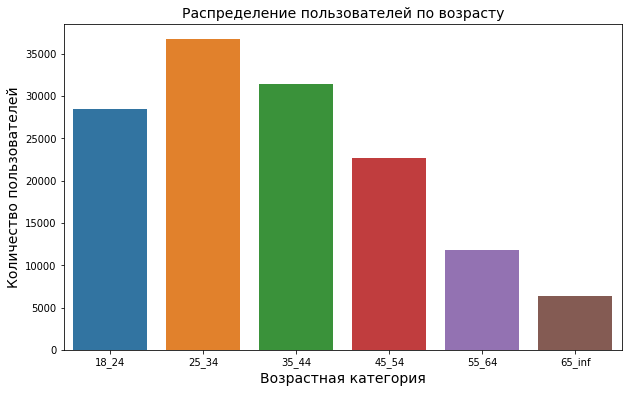

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x = users.age.sort_values())
plt.title('Распределение пользователей по возрасту',fontsize=14)
plt.xlabel('Возрастная категория',fontsize=14)
plt.ylabel('Количество пользователей',fontsize=14);

In [9]:
users.user_id.nunique() # количество различных пользователей в базе

137254

## Информация о книгах

In [10]:
items.head(3)

,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869


In [11]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63758 entries, 0 to 63757
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       63758 non-null  int64 
 1   title    63758 non-null  object
 2   genres   63753 non-null  object
 3   authors  56700 non-null  object
 4   year     49508 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


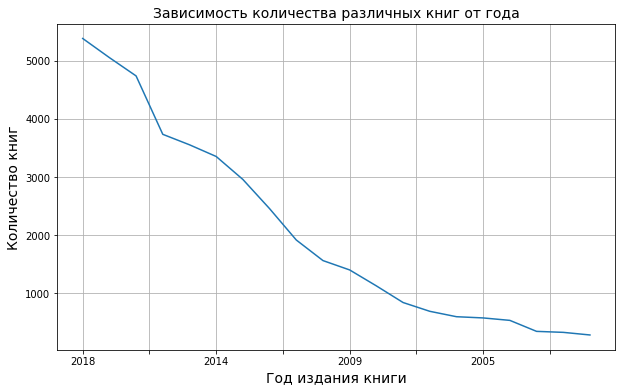

In [12]:
plt.figure(figsize=(10,6))
items.year.value_counts().sort_values(ascending=False).head(20).plot()
plt.grid()
plt.title('Зависимость количества различных книг от года',fontsize=14)
plt.xlabel('Год издания книги',fontsize=14)
plt.ylabel('Количество книг',fontsize=14);

<b> Наиболее популярные жанры в базе. </b>

In [13]:
counter = Counter()
for i in items.genres:
    if type(i)==float:
        continue
    item_genres = i.split(',')
    counter.update(item_genres)
counter.most_common(10)

[('Современная русская литература', 3893),
 ('Современные детективы', 3441),
 ('Современные любовные романы', 3247),
 ('Попаданцы', 2832),
 ('Боевая фантастика', 2814),
 ('Любовное фэнтези', 2621),
 ('Русская классика', 2537),
 ('Газеты', 2441),
 ('Героическое фэнтези', 2234),
 ('Зарубежные любовные романы', 2214)]

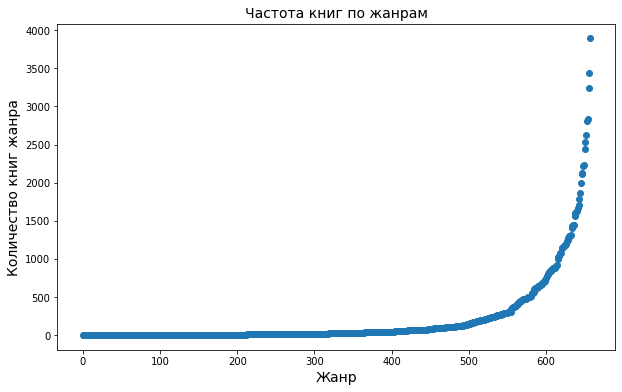

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(counter.values())),sorted(counter.values()))
plt.title('Частота книг по жанрам',fontsize=14)
plt.xlabel('Жанр',fontsize=14)
plt.ylabel('Количество книг жанра',fontsize=14);

<b> Примерно 100 жанров выделяется из всех. Остальных мало в базе. </b>

In [15]:
len(counter) # количество различных жанров

658

<b> Жанры, у которых пропущены авторы. </b>

In [16]:
counter = Counter()
for i in items.loc[items.authors.isna()].genres:
    if type(i)==float:
        continue
    item_genres = i.split(',')
    counter.update(item_genres)
counter.most_common(10)

[('Газеты', 2402),
 ('Журнальные издания', 1574),
 ('Книги по экономике', 1051),
 ('Политология', 991),
 ('Развлечения', 821),
 ('Прикладная литература', 579),
 ('Спорт / фитнес', 445),
 ('Кулинария', 364),
 ('Общая история', 292),
 ('Биографии и мемуары', 284)]

In [17]:
items.id.nunique() # количество различных книг в базе

63758

<b> Авторы с наибольшим количеством различных книг. </b>

In [18]:
items.authors.value_counts().head(10) # с учетом аудиокниг

Дарья Донцова           320
Марина Серова           319
Наталья Александрова    287
Илья Мельников          270
Антон Чехов             269
Лев Толстой             224
Александр Тамоников     217
Владимир Колычев        204
Сергей Зверев           202
Кир Булычев             183
Name: authors, dtype: int64

<b> Пример одного из авторов. </b>

In [19]:
items.iloc[np.where(items.authors=='Лев Толстой')[0]].sort_values(by='title').tail(5)

,id,title,genres,authors,year
50536,117587,Что такое религия и в чем сущность ее,"Старинная литература,Русская классика",Лев Толстой,NaN
28501,348925,Что такое религия и в чем сущность ее,"Старинная литература,Русская классика",Лев Толстой,NaN
58127,221818,Юность,"Классическая проза,Русская классика",Лев Толстой,1852
60235,99599,Юность,"Классическая проза,Русская классика",Лев Толстой,1852
277,292513,Юность,"Литература 19 века,Русская классика",Лев Толстой,1857


<b> Некоторые названия повторяются и у них разные id. Как оказалось, здесь учитваются также и аудиокниги. Что составит некоторую сложность в будущем. </b>

## Информация о действиях пользователей

In [20]:
interactions.head(5)

,user_id,item_id,progress,rating,start_date
0,90133,82910,100,NaN,2018-01-01
1,159130,331068,70,NaN,2018-01-01
2,80061,26540,69,4.0,2018-01-01
3,12811,301895,16,NaN,2018-01-01
4,5778,127872,100,NaN,2018-01-01


In [21]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562617 entries, 0 to 1562616
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1562617 non-null  int64         
 1   item_id     1562617 non-null  int64         
 2   progress    1562617 non-null  int64         
 3   rating      323571 non-null   float64       
 4   start_date  1562617 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 59.6 MB


<b> К сожалению, много пропусков в столбце рейтинга. Похоже, мало кто любит оценивать книги. </b>

In [22]:
(interactions.start_date.max()-interactions.start_date.min()).days # информация действий юзеров за 729 дня

729

In [23]:
interactions.user_id.nunique() # количество различных пользователей 

158325

In [24]:
interactions['start_date_year'] = interactions.start_date.apply(lambda x:x.year)
interactions['start_date_month'] = interactions.start_date.apply(lambda x:x.month)

In [25]:
interactions.groupby(['start_date_year'])['item_id'].count()

start_date_year
2018    778865
2019    783752
Name: item_id, dtype: int64

<b> В последние месяцы больше всего оценок. </b>

In [26]:
interactions.groupby(['start_date_month'])['rating'].count().sort_values()

start_date_month
5     24416
9     24638
4     24663
3     24926
6     25225
2     25954
8     26073
7     26712
1     26765
10    29620
11    30689
12    33890
Name: rating, dtype: int64

In [27]:
interactions.item_id.nunique() # количество различных книг (за 2 года)

63758

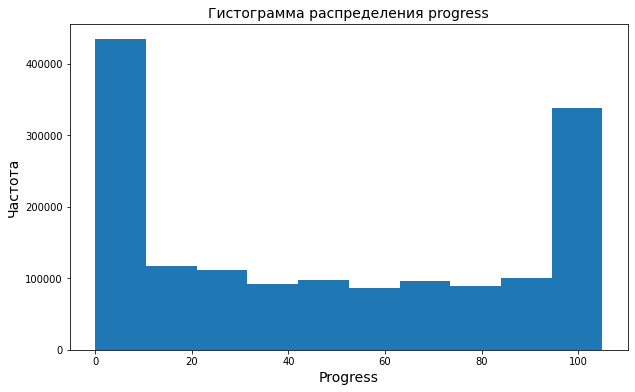

In [28]:
plt.figure(figsize=(10,6))
interactions.progress.plot.hist(bins=10)
plt.title('Гистограмма распределения progress',fontsize=14)
plt.xlabel('Progress',fontsize=14)
plt.ylabel('Частота',fontsize=14);

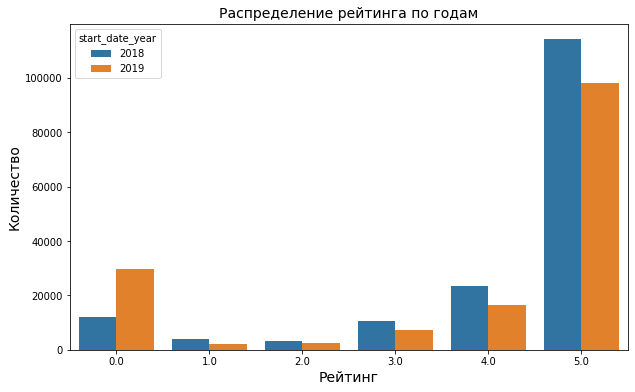

In [29]:
plt.figure(figsize=(10,6))
sns.countplot(x=interactions.rating,hue = interactions.start_date_year)
plt.title('Распределение рейтинга по годам',fontsize=14)
plt.ylabel('Количество',fontsize=14)
plt.xlabel('Рейтинг',fontsize=14);

<b> Значение 0 в рейтинге скорее всего говорит о том что пользователь отказался оценивать. В 2019 намного больше рейтинга со значением 0. </b>

<b> Cлучайная ошибка (возможно того числа были и другие ошибки). </b>

In [30]:
interactions.iloc[np.where(interactions.progress>100)[0]]

,user_id,item_id,progress,rating,start_date,start_date_year,start_date_month
1455626,6313,169716,105,0.0,2019-11-11,2019,11


<b> Топ 5 книг 2018 года (по количеству действий с ними). </b>

In [31]:
top_5_2018 = interactions.iloc[np.where(interactions.start_date_year==2018)[0]]['item_id'].\
                    value_counts().head(5).index.to_list()
top_5_2018_ind = [np.where(items.id==i)[0][0] for i in top_5_2018]
items.iloc[top_5_2018_ind][['title','authors']]

,title,authors
7069,"Сила подсознания, или Как изменить жизнь за 4 ...",Джо Диспенза
14794,Зулейха открывает глаза,Гузель Яхина
12353,Думай медленно… Решай быстро,Даниэль Канеман
13590,Черновик,Сергей Лукьяненко
5978,Ведьмак,Анджей Сапковский


<b> Топ 5 книг 2019 года (по количеству действий с ними). </b>

In [32]:
top_5_2019 = interactions.iloc[np.where(interactions.start_date_year==2019)[0]]['item_id'].\
                    value_counts().head(5).index.to_list()
top_5_2019_ind = [np.where(items.id==i)[0][0] for i in top_5_2019]
items.iloc[top_5_2019_ind][['title','authors']]

,title,authors
32256,Самая таинственная тайна и другие сюжеты,Борис Акунин
19152,Яблоки из сада Шлицбутера,Дина Рубина
49395,Зелёная миля,Стивен Кинг
20063,Сказки для идиотов (сборник),Борис Акунин
39130,Противостояние,Стивен Кинг


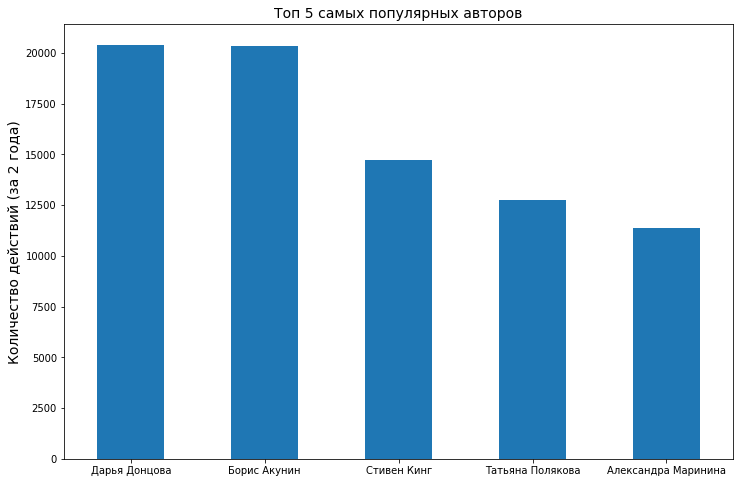

In [33]:
plt.figure(figsize=(12,8))
interactions.merge(items,left_on='item_id',right_on='id')['authors'].value_counts().head(5).plot.bar()
plt.title('Топ 5 самых популярных авторов',fontsize=14)
plt.ylabel('Количество действий (за 2 года)',fontsize=14)
plt.xticks(rotation=0);

<b> Топ 10 популярных книг. </b>

In [34]:
interactions.merge(items,left_on='item_id',right_on='id')['title'].value_counts().head(10)

Сила подсознания, или Как изменить жизнь за 4 недели    6582
Самая таинственная тайна и другие сюжеты                2701
Яблоки из сада Шлицбутера                               2571
Противостояние                                          2380
Зелёная миля                                            2341
Снеговик                                                2307
Сказки для идиотов (сборник)                            2294
Зулейха открывает глаза                                 2233
Инферно                                                 2144
Шантарам                                                2077
Name: title, dtype: int64

<b> Средние показатели юзеров (количество оценок и действий за 2 года). </b>

In [35]:
interactions.groupby('user_id')[['rating','item_id']].count().mean()

rating     2.043714
item_id    9.869679
dtype: float64

<b> Топ 5 самых оцениваемых книг. </b>

In [36]:
top_10 = interactions.groupby('item_id')['rating'].agg(['count']).\
                 sort_values(by=['count'],ascending=False).head(5)
top_10_ind = [np.where(items.id==i)[0][0] for i in top_10.index.to_list()]
items.iloc[top_10_ind][['title','genres','authors']]

,title,genres,authors
14794,Зулейха открывает глаза,Современная русская литература,Гузель Яхина
13590,Черновик,Научная фантастика,Сергей Лукьяненко
40974,Дневники стюардессы. Лихие 90-е,"Шпионские детективы,Короткие любовные романы,К...",Дарья Кова
20558,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё
27164,"Богатый папа, бедный папа. Роберт Кийосаки (об...","Личная эффективность,Саморазвитие / личностный...",Том Батлер-Боудон


In [37]:
counter = Counter()
for i in interactions.merge(items,left_on='item_id',right_on='id').genres:
    if type(i)==float:
        continue
    item_genres = i.split(',')
    counter.update(item_genres)
counter.most_common(10)

[('Любовное фэнтези', 118793),
 ('Современные детективы', 100252),
 ('Попаданцы', 96237),
 ('Современные любовные романы', 95394),
 ('Современная русская литература', 93468),
 ('Героическое фэнтези', 83024),
 ('Боевая фантастика', 75357),
 ('Зарубежные любовные романы', 71271),
 ('Саморазвитие / личностный рост', 68016),
 ('Боевое фэнтези', 64754)]

## Информация о юзерах из теста

In [38]:
sample_ind = np.array([]) # индексы в таблице юзеров
for i in sample.Id:
    sample_ind = np.append(sample_ind,np.where(users.user_id==i)[0])

In [39]:
users.loc[sample_ind].sex.value_counts()

0.0    1846
1.0     648
Name: sex, dtype: int64

In [40]:
users.loc[sample_ind].age.value_counts()

25_34     596
35_44     564
45_54     480
18_24     428
55_64     278
65_inf    181
Name: age, dtype: int64

<b> Количество пользователей, которых нет в базе (users). </b>

In [41]:
len(set(sample.Id) - set(users.user_id)) # их довольно много

547

<b> Пользователи, которые не проявляли никакой дейятельности за последние 2 года. </b>

In [42]:
set(sample.Id) - set(interactions.user_id)

{10309, 156235}

In [43]:
users.loc[(users.user_id==10309)|(users.user_id==156235)]

,user_id,age,sex
8501,10309,18_24,0.0
129118,156235,25_34,1.0


In [44]:
sample_ind = np.array([]) #индексы в таблице взаимодействий
for i in sample.Id:
    sample_ind = np.append(sample_ind,np.where(interactions.user_id==i)[0])

<b> Средние значения юзеров. </b>

In [45]:
interactions.iloc[sample_ind][['rating','progress']].mean()

rating       4.288439
progress    64.765413
dtype: float64

<b> Данные юзеры намного больше оценивают и прочитывают книги.  
    Для всего датасета среднее по юзерам: 2 оценки и 10 просмотров книг.</b>

In [46]:
interactions.iloc[sample_ind].groupby('user_id')[['rating','item_id']].count().mean()

rating      9.131185
item_id    29.831380
dtype: float64

<b> Топ 10 самых популярных авторов. </b>

In [47]:
merged_data = interactions.iloc[sample_ind].merge(items,left_on='item_id',right_on='id')
merged_data.groupby('authors')['authors'].count().sort_values(ascending=False).head(10)

authors
Елена Звездная         1895
Татьяна Полякова       1658
Дарья Донцова          1465
Татьяна Устинова        850
Александра Маринина     849
Борис Акунин            794
Анна Гаврилова          678
Артем Каменистый        651
Роман Злотников         643
Сергей Лукьяненко       639
Name: authors, dtype: int64

<b> Топ 10 самых популярных книг. </b>

In [48]:
merged_data.groupby('title')['title'].count().sort_values(ascending=False).head(10)

title
Сила подсознания, или Как изменить жизнь за 4 недели                      99
Ошибка                                                                    82
Снеговик                                                                  76
Невеста Смерти                                                            72
Земное притяжение                                                         71
Цена вопроса. Том 1                                                       69
Долина драконов. Магическая Практика                                      68
Яблоки из сада Шлицбутера                                                 67
Струны волшебства. Книга первая. Страшные сказки закрытого королевства    67
Чудовищное предложение                                                    66
Name: title, dtype: int64

<b> Топ 10 популярных жанров. </b>

In [49]:
counter = Counter()
for i in merged_data.genres:
    if type(i)==float:
        continue
    item_genres = i.split(',')
    counter.update(item_genres)
counter.most_common(10)

[('Любовное фэнтези', 18049),
 ('Попаданцы', 13734),
 ('Героическое фэнтези', 9052),
 ('Современные любовные романы', 8609),
 ('Боевая фантастика', 8440),
 ('Современные детективы', 7880),
 ('Боевое фэнтези', 6412),
 ('Книги про волшебников', 5580),
 ('Зарубежные любовные романы', 5150),
 ('Магические академии', 5092)]

<b> Топ 10 самых оцениваемых книг. </b> 

In [50]:
top_10_rated = merged_data.groupby('item_id').rating.count().sort_values(ascending=False).head(10)
top_10_rated_ind = [np.where(items.id==i)[0][0] for i in top_10_rated.index.to_list()]
items.iloc[top_10_rated_ind][['title','genres','authors']]

,title,genres,authors
48362,Вдова мастера теней,"Героическое фэнтези,Любовное фэнтези",Валентина Савенко
42671,Магическая Экспедиция,"Книги про волшебников,Любовное фэнтези,Фэнтези...",Елена Звездная
47821,Магическая сделка,"Книги про волшебников,Любовное фэнтези,Фэнтези...",Елена Звездная
47453,Мечта светлой тьмы,Любовное фэнтези,Валентина Савенко
33069,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова
41549,Долина драконов. Магическая Практика,"Любовное фэнтези,Фэнтези про драконов,Магическ...",Елена Звездная
42115,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников","Милена Завойчинская,Милена Завойчинская"
47189,Струны волшебства. Книга вторая. Цветная музык...,"Героическое фэнтези,Книги про волшебников,Любо...",Милена Завойчинская
43122,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя
40539,Мертвые Игры. Книга третья. О темных лордах и ...,"Книги про волшебников,Любовное фэнтези",Елена Звездная


<b> Доминирующее количество книг жанра фэнтези.</b>

Для теста были выбраны хорошие пользователи, которые любят читать, оценивать книги и их оценки довольно высокие. Предпочнения по жанрам и любимым авторам пользователей ясны, поэтому предположить, какую книгу они прочитают становится проще. И похоже в то время была система рекоммендаций non-personolized. 

MTS Библиотека прекрасный сервис, в котором большое количество бесплатных книг. Количество книг и пользователей с каждым годом растет. Данных вполне достаточно, чтобы узнать предпочения юзеров. Однако есть несколько сложностей. Например, из этого датасета довольно сложно предположить, хочет пользователь книгу или же аудиокнигу и какое издание.